# Figure showing the posterior validations

In [1]:
import os, glob
import numpy as np
from tqdm.notebook import tqdm, trange

In [2]:
import torch
from haloflow import data as D
from haloflow import util as U

In [3]:
import corner as DFM
# --- plotting ---
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

In [4]:
if torch.cuda.is_available(): device = 'cuda'
else: device = 'cpu'

In [5]:
qphis0 = U.read_best_ndes('msmh.v1.mags.maf', device=device)
qphis1 = U.read_best_ndes('msmh.v1.mags_morph.maf', device=device)
#qphis2 = U.read_best_ndes('msmh.v1.mags_morph_satlum_all.maf', device=device)
#qphis3 = U.read_best_ndes('msmh.v1.mags_morph_satlum_all_rich_all.maf', device=device)
qphis2 = U.read_best_ndes('msmh.v1.mags_morph_satlum_mrlim.maf', device=device)
qphis3 = U.read_best_ndes('msmh.v1.mags_morph_satlum_mrliml_rich_mrlim.maf', device=device)

2371 models trained
[1708, 1433, 79, 400, 437]
4341 models trained
[2067, 3223, 4112, 2551, 3263]
3674 models trained
[1142, 3137, 2836, 1502, 182]
3089 models trained
[1083, 897, 1676, 813, 2716]


In [6]:
y0, x0 = D.get_subhalos('test', 'mags', snapshot=91)
y1, x1 = D.get_subhalos('test', 'mags_morph', snapshot=91)
#y2, x2 = D.get_subhalos('test', 'mags_morph_satlum_all', snapshot=91)
#y3, x3 = D.get_subhalos('test', 'mags_morph_satlum_all_rich_all', snapshot=91)
y2, x2 = D.get_subhalos('test', 'mags_morph_satlum_mrlim', snapshot=91)
y3, x3 = D.get_subhalos('test', 'mags_morph_satlum_mrlim_rich_mrlim', snapshot=91)

In [7]:
# impose Mh cut on test data
mh_lim = (y0[:,1] > 11.1)
y0, x0 = y0[mh_lim], x0[mh_lim]
y1, x1 = y1[mh_lim], x1[mh_lim]
y2, x2 = y2[mh_lim], x2[mh_lim]
y3, x3 = y3[mh_lim], x3[mh_lim]

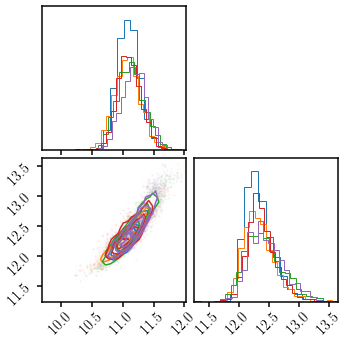

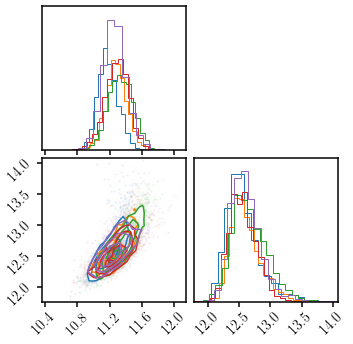

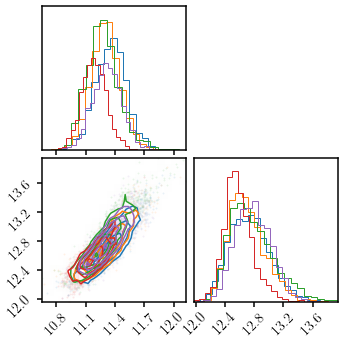

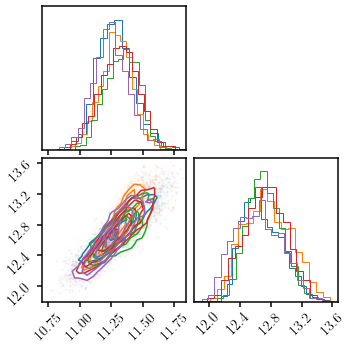

In [9]:
n_sample = 10000

i = 0 
for qphis, xs, ys in zip([qphis0, qphis1, qphis2, qphis3], [x0, x1, x2, x3], [y0, y1, y2, y3]): 
    fig = None
    for ii, qphi in enumerate(qphis): 
        nmlim, nx = 0, 1
        while nmlim < (n_sample/len(qphis0)):
            _samp = qphi.sample((int(nx * n_sample/len(qphis0)),),
                               x=torch.tensor(xs[i], dtype=torch.float32).to(device), 
                               show_progress_bars=False)
            _sam = _samp.detach().cpu().numpy()

            nmlim = np.sum((_sam[:,0] > 9.5) & (_sam[:,1] > 11.1))
            nx *= 2 

        i_sam = np.random.choice(np.arange(_sam.shape[0])[(_sam[:,0] > 9.5) & (_sam[:,1] > 11.1)], 
                                 size=int(n_sample/len(qphis0)), replace=False)                
        
        fig = DFM.corner(_sam[i_sam], color='C%i' % ii, fig=fig)
    plt.show()

In [8]:
n_sample = 10000

ranks0, ranks1, ranks2, ranks3 = [], [], [], []
y_nde0, y_nde1, y_nde2, y_nde3 = [], [], [], []

for i in trange(y0.shape[0]): 
    for qphis, ranks, y_nde, xs, ys in zip([qphis0, qphis1, qphis2, qphis3], 
                                           [ranks0, ranks1, ranks2, ranks3], 
                                           [y_nde0, y_nde1, y_nde2, y_nde3], 
                                           [x0, x1, x2, x3], [y0, y1, y2, y3]): 
        y_samp = []
        for qphi in qphis: 
            nmlim, nx = 0, 1
            while nmlim < (n_sample/len(qphis0)):
                _samp = qphi.sample((int(nx * n_sample/len(qphis0)),),
                                   x=torch.tensor(xs[i], dtype=torch.float32).to(device), 
                                   show_progress_bars=False)
                _sam = _samp.detach().cpu().numpy()
                
                nmlim = np.sum((_sam[:,0] > 9.5) & (_sam[:,1] > 11.1))
                nx *= 2 
            
            i_sam = np.random.choice(np.arange(_sam.shape[0])[(_sam[:,0] > 9.5) & (_sam[:,1] > 11.1)], 
                                     size=int(n_sample/len(qphis0)), replace=False)                
            y_samp.append(_sam[i_sam])
        y_nde.append(np.concatenate(np.array(y_samp), axis=0))        
    
        _ranks = []
        for i_dim in range(y_nde[-1].shape[1]): 
            _ranks.append(np.mean(y_nde[-1][:,i_dim].flatten() < ys[i, i_dim]))
        ranks.append(_ranks)
    
ranks0 = np.array(ranks0)
ranks1 = np.array(ranks1)
ranks2 = np.array(ranks2)
ranks3 = np.array(ranks3)

y_nde0 = np.array(y_nde0)
y_nde1 = np.array(y_nde1)
y_nde2 = np.array(y_nde2)
y_nde3 = np.array(y_nde3)

  0%|          | 0/476 [00:00<?, ?it/s]

In [9]:
from tarp import get_drp_coverage

In [10]:
alpha0, ecp0 = get_drp_coverage(np.swapaxes(y_nde0, 0, 1), y0, references="random", metric="euclidean")
alpha1, ecp1 = get_drp_coverage(np.swapaxes(y_nde1, 0, 1), y1, references="random", metric="euclidean")
alpha2, ecp2 = get_drp_coverage(np.swapaxes(y_nde2, 0, 1), y2, references="random", metric="euclidean")
alpha3, ecp3 = get_drp_coverage(np.swapaxes(y_nde3, 0, 1), y3, references="random", metric="euclidean")

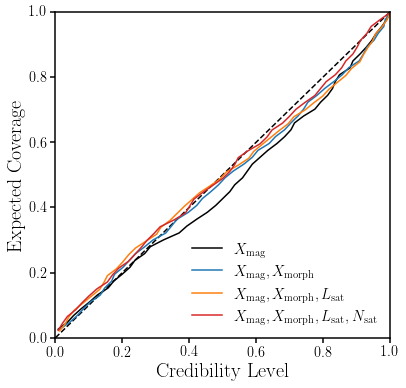

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(6,6))
ax.plot([0, 1], [0, 1], ls="--", color="k")
ax.plot(alpha0, ecp0, c='k', label=r'$X_{\rm mag}$')
ax.plot(alpha1, ecp1, c='C0', label=r'$X_{\rm mag}, X_{\rm morph}$')
ax.plot(alpha2, ecp2, c='C1', label=r'$X_{\rm mag}, X_{\rm morph}, L_{\rm sat}$')
ax.plot(alpha3, ecp3, c='C3', label=r'$X_{\rm mag}, X_{\rm morph}, L_{\rm sat}, N_{\rm sat}$')
ax.legend(loc='lower right', fontsize=15)
ax.set_ylabel("Expected Coverage", fontsize=20)
ax.set_ylim(0., 1.)
ax.set_xlabel("Credibility Level", fontsize=20)
ax.set_xlim(0., 1.)
fig.savefig('figs/valid_tarp.pdf', bbox_inches='tight')